# Data cleaning 

This notebook is used to clean the datasets available in the `raw` file. It has already been run once, generating the files in the `clean` data file. Note that the file named `data.csv`, which contains data facilitated directly by UNHCR, is not currently available in the repository due to privacy issues.   

In [1]:
import pandas as pd
import numpy as np

### Clean the UNHCR dataset
To clean the UNHCR data, we:
- Drop duplicate rows for Antigua and Barbuda
- Replace non contiguous values with contiguous values where necessary
- Remove problematic observations based on UNHCR recommendations.

In [2]:
# remove duplicate rows
df = pd.read_csv('raw/data.csv',engine='pyarrow').drop_duplicates(['Id','year']).drop('', axis=1)

# replace contig values that should be ones but are zeros
df.loc[df.Id.isin(['CODUGA','UGACOD','SDNSSD','SSDSDN','SSDETH','ETHSSD','SSDUGA',
                   'UGASSD','CODCOG','COGCOD','CAFCOD','CODCAF','CODBDI','BDICOD',
                   'SSDKEN','KENSSD','SSDCOD','CODSSD','CODZMB','ZMBCOD','AUTHUN','HUNAUT',
                     'UVKALB','ALBUVK','MNEALB','ALBMNE','WBGISR','ISRWBG','JORWBG','WBGJOR',
                     'BGRSRB','SRBGBR','ROUSRB','SRBROU','HUNSRB','SRBHUN']), 'contig'] = 1

# sudan isn't contiguous with kenya after 2011
# df.loc[df.Id.isin(['KENSDN','SDNKEN']), 'contig'] = 0 

# remove problematic observations
df.loc[(df.Id == 'CODAGO') & df.year.isin([2017, 2018]), 'newarrival'] = np.nan

df.loc[df.Id == 'AFGIRN', 'newarrival']= np.nan

df.loc[df.Id == 'AFGPAK', 'newarrival'] = np.nan

df.loc[df.Id == 'ERTSDN', 'newarrival']= np.nan

df.loc[(df.Id == 'SYRTUR') & (df.year > 2018), 'newarrival']= np.nan

# any newarrivals after 2021 set to nan
df.loc[df.year > 2021, 'newarrival'] = np.nan

df.to_csv('clean/unhcr.csv', index=False)

Note there are some countries which the distances are the exact same for all pairs:

In [492]:
countries = df.iso_o.unique()

In [495]:
sus_country_distances = []
for country in countries:
    if len(df.loc[df.iso_o == country, 'dist'].unique()) == 1:
        sus_country_distances.append(country)

In [504]:
sus_country_distances

['COD', 'UVK', 'MNE', 'SRB', 'SSD', 'WBG']

### Cleaning the Migration data
This migration stock data comes from [Our World in Data](https://ourworldindata.org/migration#explore-data-on-where-people-migrate-from-and-to)
It is every five years from 1990 to 2020.

- We read the data in
- Add 2021
- Melt it to long format
- We forward fill the data because these migration stocks are only released every five years.
- Use country converter to convert names to iso 3 codes.

In [88]:
df = pd.read_csv('raw/migration-flows.csv', engine='pyarrow').rename({'Year':'year'},axis=1)
df = df.loc[:,~df.columns.str.contains('_origin|_destination')]
df = df[df.year >= 2000]

df['year'] = pd.to_datetime(df.year, format='%Y')

df_2021 = df[df.year == pd.to_datetime('2020', format='%Y')].copy()

# change 2020 to 2021
df_2021['year'] += pd.Timedelta(366, unit='d')

# concatenate 2021 w/ rest
df = pd.concat([df, df_2021], axis=0)

Melt the data frame, and fill in missing years.

In [89]:
# melt df, split Emigrants Immigrants columns, filter out rows with same origin and destination
df = df.melt(id_vars=['Country','year'], var_name='Country_d').rename({'Country':'Country_o'}, axis=1).fillna(0)
df[['EmigrantsImmigrants', 'Country_d']] =  df.Country_d.str.split(' from | to ', expand=True)
df = df[(df.Country_d != df.Country_o)]

# for values that say emigrants, switch the origin with destination
emigrants_mask = df['EmigrantsImmigrants'] == 'Emigrants'
df.loc[emigrants_mask, ['Country_o', 'Country_d']] = df.loc[emigrants_mask, ['Country_d', 'Country_o']].values

df = df[['year', 'Country_o', 'EmigrantsImmigrants', 'Country_d', 'value']].drop('EmigrantsImmigrants', axis=1).drop_duplicates(['year','Country_o','Country_d'])
df.value = df.value.abs()

Country long names get replaced with iso 3 short names using country converter.

In [90]:
# convert the country names to iso3
import country_converter as coco
iso3_unique = coco.convert(names=df.Country_o.unique(), to='ISO3')
iso_3_dict = dict(zip(df.Country_o.unique(), iso3_unique))

df[['Country_o','Country_d']] = df[['Country_o','Country_d']].apply(lambda x: x.map(iso_3_dict))
df.rename({'Country_o':'iso_o','Country_d':'iso_d', 'value':'migration_stock'}, axis=1,inplace=True)

Caribbean not found in regex
Channel Islands not found in regex


Polynesia not found in regex


In [91]:
# I convert stock data to the percent of migrants both from the perspective of the origin country and destination country.
unhcr_data = pd.read_csv('clean/unhcr.csv', engine='pyarrow')[['iso_o','iso_d','year','pop_o','pop_d']].drop_duplicates(['iso_o','iso_d','year'])

In [92]:
df.rename({'year':'Year'}, inplace=True, axis=1)
df['year'] = df.Year.dt.year

In [93]:
df = unhcr_data.merge(df, on=['iso_o','iso_d','year'], how='left')
df[['pop_o','pop_d']] = df[['pop_o','pop_d']].apply(lambda x: x * 1000000)
df[['migration_stock_pct_o','migration_stock_pct_d']] = df[['pop_o','pop_d']].apply(lambda x: df.migration_stock*100/x)

In [85]:
df[~df.migration_stock.isna()]

,iso_o,iso_d,year,pop_o,pop_d,Year,migration_stock,migration_stock_pct_o,migration_stock_pct_d
0,AFG,ALB,2000,19500000.0,3089000.0,2000-01-01,0.0,0.000000,0.000000
5,AFG,ALB,2005,20947000.0,3011000.0,2005-01-01,0.0,0.000000,0.000000
10,AFG,ALB,2010,24269000.0,2913000.0,2010-01-01,0.0,0.000000,0.000000
15,AFG,ALB,2015,28425000.0,2881000.0,2015-01-01,0.0,0.000000,0.000000
20,AFG,ALB,2020,32941000.0,2878000.0,2020-01-01,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
955480,ZWE,ZMB,2005,11830000.0,12044000.0,2005-01-01,12444.0,0.105190,0.103321
955485,ZWE,ZMB,2010,12340000.0,13917000.0,2010-01-01,17226.0,0.139595,0.123777
955490,ZWE,ZMB,2015,14009000.0,16212000.0,2015-01-01,13175.0,0.094047,0.081267
955495,ZWE,ZMB,2020,15189000.0,18882000.0,2020-01-01,16816.0,0.110712,0.089058


In [94]:
df = df.drop(['pop_o','pop_d','Year'],axis=1).rename({'Year':'year'},axis=1)

In [95]:
# fill in missing years.
df = df.set_index(['year','iso_o','iso_d']).groupby(['iso_o', 'iso_d']).fillna(method='ffill')
df.reset_index(inplace=True)
df['years_since_migration_report'] = df.year % 5

# The remaning two countries ('WBG' and 'UVK'), do mean imputation.
df[['migration_stock', 'migration_stock_pct_o','migration_stock_pct_d']] = df[['migration_stock', 'migration_stock_pct_o','migration_stock_pct_d']].apply(lambda x: x.fillna(value = x.mean()))

In [418]:
# write to csv
df.to_csv('clean/migration_stocks.csv', index=False)

### Cleaning IDP data 

This IDP data on internally displaced people comes from the IDMC https://www.internal-displacement.org/database/displacement-data.

It is yearly from 2008 to 2022, and contains data on both the stock of internally displace peoples and the new amount that year.

As a prior, let's say that disaster idp is irrelevant to refugee newarrivals and drop disaster idp data.

In [9]:
# read in an rename columns
idp_df = pd.read_excel('raw/IDMC_Internal_Displacement_Conflict-Violence_Disasters.xlsx').rename({'Year':'year','Name':'Country','ISO3':'iso','Conflict Stock Displacement (Raw)':'conflict_stock_idp', 'Conflict Internal Displacements (Raw)':'conflict_idp',
       'Disaster Internal Displacements (Raw)':'disaster_idp',
       'Disaster Stock Displacement (Raw)':'disaster_stock_idp'}, axis=1).drop(['Country','Conflict Stock Displacement','Conflict Internal Displacements','Disaster Internal Displacements','Disaster Stock Displacement', 
       'disaster_stock_idp','disaster_idp'], axis=1)

unhcr_data = pd.read_csv('raw/data.csv', engine='pyarrow')[['iso_o','year','pop_o']].drop_duplicates(['iso_o','year'])
newarrival_o = pd.read_csv('raw/data.csv', engine='pyarrow').groupby(['iso_o','year']).newarrival.sum().reset_index()
unhcr_data = unhcr_data.merge(newarrival_o, on=['iso_o','year'], how='left')

In [528]:
merged_idp = unhcr_data.merge(idp_df, how='left', left_on=['iso_o','year'], right_on=['iso','year']).drop('iso',axis=1)
#merged_idp['disaster_pct'] = (merged_idp.disaster_idp/merged_idp.pop_o/1000000)

There is a significant amount of data that are missing in the idp data:

In [529]:
print('proportion missing')
merged_idp.isna().sum() / merged_idp.shape[0]

proportion missing


iso_o                 0.000000
year                  0.000000
pop_o                 0.000000
newarrival            0.000000
conflict_stock_idp    0.852041
conflict_idp          0.864694
dtype: float64

Can we assume that this data is missing because the values should be zero?

In [530]:
# number of rows where conflict data is missing AND the number of refugees is greater than 10,000 AND the year is greater than equal to 2008
merged_idp[merged_idp.conflict_idp.isna() & (merged_idp.newarrival > 1000) & (merged_idp.year >= 2008)].sort_values(by='newarrival', ascending=False)

,iso_o,year,pop_o,newarrival,conflict_stock_idp,conflict_idp
4768,VEN,2018,28.903,2508056.5,NaN,NaN
4769,VEN,2019,27.817,1524435.0,NaN,NaN
4771,VEN,2021,27.586,664573.0,NaN,NaN
4770,VEN,2020,27.951,572356.0,NaN,NaN
3933,SOM,2008,11.400,150764.0,NaN,NaN
...,...,...,...,...,...,...
2965,MOZ,2015,27.042,1005.0,NaN,NaN
3566,ROU,2016,19.761,1004.0,NaN,NaN
3011,NAM,2011,2.116,1003.0,NaN,NaN
4760,VEN,2010,28.524,1002.0,NaN,NaN


In [531]:
# number of rows where the number of refugees is greater than 10,000 AND the year is greater than equal to 2008
merged_idp[(merged_idp.newarrival > 1000) & (merged_idp.year >= 2008) ]

,iso_o,year,pop_o,newarrival,conflict_stock_idp,conflict_idp
8,AFG,2008,22.997,29698.0,NaN,NaN
9,AFG,2009,23.596,41719.0,297000.0,0.0
10,AFG,2010,24.269,38424.0,352000.0,102000.0
11,AFG,2011,25.031,45420.0,450000.0,186000.0
12,AFG,2012,25.864,60632.0,492000.0,100400.0
...,...,...,...,...,...,...
4891,ZWE,2016,14.228,9435.0,NaN,NaN
4892,ZWE,2017,14.437,4523.0,NaN,NaN
4893,ZWE,2018,14.642,1908.0,NaN,NaN
4894,ZWE,2019,14.905,3371.0,NaN,NaN


It seems that that half of the 1/2 of the outflows where the total number of outflows is greater than 1,000 are missing. This means that missing data isn't simply zero, and it actually is missing data.

We'll need to convert this to some sort of categorical variable if we want to use it.

Here is the current approach. Where we do $$log(\frac{conflict\_variable}{population \text{ (in 1000s)}} + .0001)$$

The .0001 is to ensure that an error isn't produced.

In [532]:
merged_idp['conflict_idp_pop'] = merged_idp.apply(lambda row: np.log((row['conflict_idp'] / row['pop_o']) * 1000 + 0.1), axis=1)
merged_idp['conflict_stock_idp_pop'] = merged_idp.apply(lambda row: np.log((row['conflict_stock_idp'] / row['pop_o']) * 1000 + 0.1), axis=1)

When we do this, we get a distribution where the values are mostly between -6 and 6. The most common value before was zero, which is what the value to the left of -8 is.

To convert to categorical variable, we first convert to a string.

In [520]:
merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']] = merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']].apply(lambda x: np.round(x).astype(str))
merged_idp.drop(['pop_o','newarrival','conflict_stock_idp','conflict_idp'], axis=1, inplace=True)

Then we do binary encoding.

In [456]:
from category_encoders.binary import BinaryEncoder
be = BinaryEncoder()
idp_binary = be.fit_transform(merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']])
idp_binary = pd.concat([merged_idp.drop(['conflict_stock_idp_pop', 'conflict_idp_pop'], axis=1), idp_binary],axis=1)

idp_binary.sample(10)

,iso_o,year,conflict_stock_idp_pop_0,conflict_stock_idp_pop_1,conflict_stock_idp_pop_2,conflict_stock_idp_pop_3,conflict_stock_idp_pop_4,conflict_idp_pop_0,conflict_idp_pop_1,conflict_idp_pop_2,conflict_idp_pop_3,conflict_idp_pop_4
4361,TLS,2011,0,1,1,0,1,0,0,1,1,0
2346,KGZ,2021,0,1,1,1,1,0,0,1,0,0
156,ARG,2006,0,0,0,0,1,0,0,0,0,1
2397,LVA,2022,0,0,0,0,1,0,0,0,0,1
3061,NPL,2011,0,0,1,1,0,0,0,0,1,0
3341,PAN,2016,0,0,0,0,1,0,0,0,0,1
400,BLR,2000,0,0,0,0,1,0,0,0,0,1
4384,TGO,2009,0,1,1,0,0,0,0,0,1,0
4079,LCA,2004,0,0,0,0,1,0,0,0,0,1
1507,FRA,2007,0,0,0,0,1,0,0,0,0,1


The result is 4 columns for each variable, where the values ranging from -8 to 6 or so have been encoded. The missing nan has also been encoded as a unique variable.

In [74]:
idp_binary.to_csv('clean/idp.csv')

### Fragile States Index

Source [here](https://fragilestatesindex.org/).

It is yearly from 2006-2022 and contains info on 179 countries. The remaining countries we impute, taking an average of neighbors' fragilitity indices.

In [478]:
unhcr_data = pd.read_csv('clean/unhcr.csv', engine='pyarrow').drop_duplicates(['iso_o','year'])[['iso_o','year','newarrival','Country_o']]
unhcr_data = unhcr_data[(unhcr_data.year > 2005) & (unhcr_data.year < 2023)]

In [15]:
import igraph as ig
unhcr = pd.read_csv('clean/unhcr.csv', engine='pyarrow').groupby(['iso_o','iso_d']).agg({'newarrival':'sum','contig':'first','Country_o':'first','Country_d':'first', 'island_o':'first','dist':'first'}).reset_index()

df_network = unhcr[unhcr.contig == 1]

graph = ig.Graph.TupleList(df_network[['Country_o','Country_d','dist']].itertuples(index=False), directed=False, edge_attrs='dist')

add

# graph.vs['name'] = coco.convert(graph.vs['name'], to='iso3')

In [20]:
# load excel files in
import os
path = 'raw/fsi 2022-2006/'
fsi_files = os.listdir(path)
fsi_files = path + pd.Series(fsi_files)
fsi_df = pd.concat(fsi_files.apply(lambda x: pd.read_excel(x)).tolist())

In [27]:
# rename columns
fsi_df = fsi_df.rename({'Year':'year', 'Total':'fsi_overall', 'C1: Security Apparatus':'fsi_security_apparatus',
       'C2: Factionalized Elites':'fsi_factionalized_elites', 'C3: Group Grievance':'fsi_group_grievance', 'E1: Economy':'fsi_economy',
       'E2: Economic Inequality':'fsi_economic_inequality', 'E3: Human Flight and Brain Drain':'fsi_human_flight_brain_drain',
       'P1: State Legitimacy':'fsi_state_legitimacy', 'P2: Public Services':'fsi_public_services', 'P3: Human Rights':'fsi_human_rights',
       'S1: Demographic Pressures':'fsi_demographic_pressures', 'S2: Refugees and IDPs':'fsi_refugees_idps',
       'X1: External Intervention':'fsi_external_intervention'}, axis=1).drop(['Change from Previous Year','Rank'],axis=1)

# Change an error causing country name. Israel and West Bank -> West Bank and Gaza (consistent with the UNHCR naming convention)
fsi_df.loc[fsi_df.Country == 'Israel and West Bank', "Country"] = 'West Bank and Gaza'

In [31]:
# convert country name to iso3
import country_converter as coco
iso3_unique = coco.convert(names=fsi_df.Country.unique(), to='ISO3')

iso_3_dict = dict(zip(fsi_df.Country.unique(), iso3_unique))

fsi_df['iso'] = fsi_df['Country'].map(iso_3_dict)

fsi_df['year'] = fsi_df['year'].apply(lambda x: x.year if isinstance(x, pd.Timestamp) else x)

In [553]:
# for those who are missing fragility indices, filter for neighbors and take average of that
fsi_full = unhcr_data.merge(fsi_df, how='left',left_on=['iso_o','year'], right_on=['iso','year'])

In [554]:
# for those who are missing fragility indices, filter for neighbors and take average of that
missing_indices = unhcr_data.set_index(['iso_o','year'])[unhcr_data.merge(fsi_df, how='left',left_on=['iso_o','year'], right_on=['iso','year']).set_index(['iso_o','year']).fsi_overall.isna()].reset_index()[['Country_o','year']]

for index, row in missing_indices.iterrows():
    bordering = graph.vs[graph.neighborhood(row['Country_o'], order=1)]['name'][1:]
    
    # take the mean of the neighboring countries
    if len(bordering) > 0:
        fsi_full.loc[(fsi_full.Country_o == row.Country_o) & (fsi_full.year == row.year), fsi_full.columns.str.contains('fsi')] = fsi_full.loc[fsi_full.Country_o.isin(bordering) & (fsi_full.year == row['year']) , fsi_full.columns.str.contains('fsi')].agg('mean').tolist()
    # if there are no bordering countries (island), take the 5 closest countries and average. If there are still na's, then take the closest 9 countries.
    elif len(unhcr[unhcr.Country_o == row.Country_o].dist.unique()) > 1:
        idx = unhcr[unhcr.Country_o == row.Country_o].dist.nsmallest(4).index
        closest_countries = unhcr.iloc[idx].Country_d
        neighboring_fsi_indices = fsi_full.loc[fsi_full.Country_o.isin(closest_countries) & (fsi_full.year == row.year), fsi_full.columns.str.contains('fsi')].agg('mean')
        if neighboring_fsi_indices.isna().sum() == 0:
            fsi_full.loc[(fsi_full.Country_o == row.Country_o) & (fsi_full.year == row.year), fsi_full.columns.str.contains('fsi')] = neighboring_fsi_indices.tolist()
        else:
            idx = unhcr[unhcr.Country_o == row.Country_o].dist.nsmallest(9).index
            closest_countries = unhcr.iloc[idx].Country_d
            neighboring_fsi_indices = fsi_full.loc[fsi_full.Country_o.isin(closest_countries) & (fsi_full.year == row.year), fsi_full.columns.str.contains('fsi')].agg('mean')
            fsi_full.loc[(fsi_full.Country_o == row.Country_o) & (fsi_full.year == row.year), fsi_full.columns.str.contains('fsi')] = neighboring_fsi_indices.tolist()

In [571]:
fsi_full.drop(['Country','Country_o','newarrival','iso'], axis=1).rename({'iso_o':'iso'},axis=1).to_csv('clean/fragility_indices.csv', index=False)

### LDA modeled Newspaper Text/Conflict Risk

Source: https://conflictforecast.org/

Extra data provided directly by the researchers leading this project.

In [65]:
import pandas as pd
# we read in the data, remove nas, and drop the first column for each forecast. 
ons_armedconf1 = pd.read_csv('raw/ons_armedconf12_f_12_d_50_t_700_depth_7_mins_2_minl_50pctrial_low_pop_og.csv')
ons_armedconf1 = ons_armedconf1.loc[~ons_armedconf1.isna().any(axis=1)].iloc[:, 1:ons_armedconf1.shape[1]]

ons_armedconf2 = pd.read_csv('raw/ons_armedconf12_f_12_d_50_t_700_depth_7_mins_2_minl_100pctrial_low_pop_og.csv')
ons_armedconf2 = ons_armedconf2.loc[~ons_armedconf2.isna().any(axis=1)].iloc[:, 1:ons_armedconf2.shape[1]]

ons_armedconf3 = pd.read_csv('raw/lnbest_pc_12_f_12_d_50_t_700_depth_7_mins_2_minl_75intensity_pc_og.csv')
ons_armedconf3 = ons_armedconf3.loc[~ons_armedconf3.isna().any(axis=1)].iloc[:, 1:ons_armedconf3.shape[1]]

#lda data
lda = pd.read_csv('raw/LDA output Mueller and Rauh.csv')
lda = lda[lda.year >= 2000]

In [66]:
# merge the conflict forecasts together
merged_armed_conf = ons_armedconf1.merge(ons_armedconf2, on = ['isocode','year', 'month']).merge(ons_armedconf3, on = ['isocode','year', 'month'])

In [71]:
# fill in the missing data 
unhcr_data = pd.read_csv('clean/unhcr.csv', engine='pyarrow').drop_duplicates(['iso_o','year'])[['iso_o','year','Country_o']]
unhcr_data = unhcr_data[ (unhcr_data.year < 2023)]

lda_full = unhcr_data.merge(lda, left_on=['iso_o','year'], right_on=['isocode','year'],how='left').drop('isocode',axis=1).rename({'iso_o':'isocode'},axis=1)
conflict_full = unhcr_data.merge(merged_armed_conf, left_on=['iso_o','year'], right_on=['isocode','year'],how='left').drop('isocode',axis=1).rename({'iso_o':'isocode'},axis=1)

In [76]:
lda_full[~lda_full.best.isna()].isocode.unique().__len__()

190

In [384]:
def prepare_data_for_resampling(dataframe):
    # Create a new DataFrame with a complete range of dates and reindex the original DataFrame
    min_date = pd.to_datetime('2000-01-01')
    max_date = pd.to_datetime('2023-01-01')
    reindexed_df = dataframe.reindex(pd.date_range(start=min_date, end=max_date, freq='MS'))

    return reindexed_df

def resample_missing_dates(dataframe):
    dataframe = dataframe.copy()

    dataframe.loc[dataframe.month.isna(), 'month'] = 1

    # Combine 'year' and 'month' columns into a single column
    dataframe['date'] = pd.to_datetime(dataframe['year'].astype(str) + '-' + dataframe['month'].astype(int).astype(str), format='%Y-%m')
    
    # Set the 'date' column as the index
    dataframe.set_index('date', inplace=True)
    
    # Resample the dataframe to fill missing year-month values for each country
    resampled_dataframe = dataframe.groupby(['Country_o','isocode'], as_index=False).apply(prepare_data_for_resampling)
    resampled_dataframe = resampled_dataframe.droplevel(0).groupby(['Country_o','isocode']).apply(lambda x: x.resample('MS').asfreq())

    # Reset the index to get back the 'date' column
    resampled_dataframe = resampled_dataframe.drop(['Country_o','year','month','isocode'], axis=1).reset_index().rename({'level_2':'date'},axis=1)

    # Split the 'date' column back into 'year' and 'month'
    resampled_dataframe['year'] = resampled_dataframe['date'].dt.year
    resampled_dataframe['month'] = resampled_dataframe['date'].dt.month
    resampled_dataframe.drop('date', axis=1, inplace=True)
    
    return resampled_dataframe

lda_full = resample_missing_dates(lda_full)
conflict_full = resample_missing_dates(conflict_full)

In [385]:
lda_cols = ['tokens', 'obs',
       'sentiment_words', 'uncertainty', 'ste_theta0', 'ste_theta1',
       'ste_theta2', 'ste_theta3', 'ste_theta4', 'ste_theta5', 'ste_theta6',
       'ste_theta7', 'ste_theta8', 'ste_theta9', 'ste_theta10', 'ste_theta11',
       'ste_theta12', 'ste_theta13', 'ste_theta14', 'ste_theta0_stock',
       'ste_theta1_stock', 'ste_theta2_stock', 'ste_theta3_stock',
       'ste_theta4_stock', 'ste_theta5_stock', 'ste_theta6_stock',
       'ste_theta7_stock', 'ste_theta8_stock', 'ste_theta9_stock',
       'ste_theta10_stock', 'ste_theta11_stock', 'ste_theta12_stock',
       'ste_theta13_stock', 'ste_theta14_stock', 'sentiment_stock',
       'uncertainty_index', 'best']
conflict_cols = ['ons_armedconf12_pred_jut_x',
       'ons_armedconf12_pred_top_x', 'ons_armedconf12_pred_aug_x',
       'ons_armedconf12_pred_jut_y', 'ons_armedconf12_pred_top_y',
       'ons_armedconf12_pred_aug_y', 'lnbest_pc_12_pred_jut',
       'lnbest_pc_12_pred_top', 'lnbest_pc_12_pred_aug']

In [386]:
# Helper function to calculate mean of neighboring countries
def calculate_mean_neighbors(dataframe, row, bordering, cols):
    if len(bordering) > 0:
        return dataframe.loc[dataframe.Country_o.isin(bordering) & (dataframe.year == row['year']) & (dataframe.month == row['month']), cols].agg('mean').tolist()
    else:
        idx = unhcr[unhcr.Country_o == row.Country_o].dist.nsmallest(4).index
        closest_countries = unhcr.iloc[idx].Country_d
        neighboring_indices = dataframe.loc[dataframe.Country_o.isin(closest_countries) & (dataframe.year == row.year) & (dataframe.month == row.month), cols].agg('mean')
        if neighboring_indices.isna().sum() == 0:
            return neighboring_indices.tolist()
        else:
            idx = unhcr[unhcr.Country_o == row.Country_o].dist.nsmallest(9).index
            closest_countries = unhcr.iloc[idx].Country_d
            neighboring_indices = dataframe.loc[dataframe.Country_o.isin(closest_countries) & (dataframe.year == row.year) & (dataframe.month == row.month), cols].agg('mean')
            return neighboring_indices.tolist()

def is_match(df, row):
    return (df.Country_o == row.Country_o) & (df.year == row.year) & (df.month == row.month)

# Process missing fragility indices in lda_full dataframe
missing_indices_lda = lda_full[lda_full.ste_theta0.isna()][['Country_o','year','month']]


for index, row in missing_indices_lda.iterrows():
    bordering = graph.vs[graph.neighborhood(row['Country_o'], order=1)]['name'][1:]
    lda_full.loc[is_match(lda_full, row), lda_cols] = calculate_mean_neighbors(lda_full, row, bordering, lda_cols)

# Process missing fragility indices in conflict_full dataframe
missing_indices_conflict = conflict_full[conflict_full.ons_armedconf12_pred_top_y.isna()][['Country_o','year','month']]

for index, row in missing_indices_conflict.iterrows():
    bordering = graph.vs[graph.neighborhood(row['Country_o'], order=1)]['name'][1:]
    conflict_full.loc[is_match(conflict_full, row), conflict_cols] = calculate_mean_neighbors(conflict_full, row, bordering, conflict_cols)

In [391]:
# write to file
conflict_full.to_csv('clean/mueller_conflict_forecasts.csv')
lda_full.to_csv('clean/lda.csv')

## GDELT

Data on conflict from https://www.gdeltproject.org/ was preprocessed by Giovanna Chaves, Margherita Philipp and Luis Quiñones. The scripts for the data scraping, cleaning and processing is available [here](https://github.com/luisquinonesPR/thesis).

In [433]:
import pandas as pd
gdelt = pd.read_csv('raw/final_gdelt_bycountry.txt', engine='pyarrow')

# replace XKX code with  UNHCR code for Kosovo
gdelt.loc[gdelt.isocode == 'XKX', 'isocode'] = 'UVK'

# add WBG (just assume the same freqeuency of events as Israel)
WBG = gdelt.reset_index().copy()
WBG = WBG[WBG.isocode.isin(['ISR'])].copy().reset_index(drop=True)
WBG.loc[:, 'isocode'] = 'WBG'

gdelt = pd.concat([gdelt, WBG], axis=0)

# aggregate goldstein, taking avg goldstein score by month
goldstein = gdelt[gdelt.year >=2000].set_index(['year','month','isocode'])['AvgGoldsteinScale'].groupby(['year','month','isocode']).agg(lambda x: x.fillna(x.mean()).mean())

# if no goldstein that month, fill by year
goldstein = goldstein.groupby(['year','isocode'], group_keys=False).apply(lambda x: x.fillna(x.mean()))
# if none in the year, impute the mean
goldstein = goldstein.fillna(goldstein.mean())

gdelt = gdelt.loc[gdelt.year >=2000, ~gdelt.columns.str.contains('ADM1Code|Actor|gov|opp|Goldstein')].groupby(['year','month','isocode']).agg(sum)

# to account for the variance in recording of events across time, divide by the total number of events for that country/year
gdelt = gdelt.div(gdelt.sum(axis=1), axis=0)
gdelt = pd.concat([gdelt, goldstein], axis=1)

gdelt.to_csv('clean/gdelt.csv')

Alternate usage of GDELT: region specific data

In [10]:
import pandas as pd
ADM1 = pd.read_json('https://raw.githubusercontent.com/gdelt/gdelt.github.io/master/data/LOOKUP-ADM1.json')
ADM1 = pd.concat([ADM1, ADM1.name.str.split(', ', n=1, expand=True).rename({0:'ADM1_name', 1:'Country'},axis=1)], axis=1)

In [38]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myapplication")


def create_converter_dict(series, converter, batch = False):
    unique_keys = series.drop_duplicates()
    if batch == True:
        unique_vals = converter(unique_keys)
    else:
        unique_vals = unique_keys.apply(converter)
    mapper_dict = dict(zip(unique_keys, unique_vals))
    return mapper_dict

def location_to_lat_long(location):
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    locations = []
    for loc in location:
        _loc = geocode(loc)
        if _loc == None:
            locations.append(None)
        else:
            locations.append(_loc[1])
    # locations = [geocode(loc)[1] for loc in location]
    return locations

lat_long_dict = create_converter_dict(ADM1.name[~ADM1.name.isna()], location_to_lat_long, batch=True)



RateLimiter caught an error, retrying (0/2 tries). Called with (*('Bristol, City of, United Kingdom',), **{}).
Traceback (most recent call last):
  File "/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
                       ^^^^^^^^^^^^^^^^^^
  File "/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/http/client.py", line 1375, in getresponse
    response.begin()
  File "/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/http/client.py", line 279, i

In [42]:
import json
with open('clean/ADM1_lat_long.json', 'w') as outfile:
    json.dump(lat_long_dict, outfile)

test = pd.read_json('clean/ADM1_lat_long.json').T.rename({0:'latitude',1:'longitude'},axis=1)

Running this yielded 1 of 3 results for each ADM1 code:
- We got the latitude and longitude for a specific code. (Yay!)
- We got the latitude and longitude, but it appears that there's more than one code with the same coordinates.
- We didn't get anything.

In [80]:
# a sample of codes for which we didn't get any coordinates:
ADM1['lat_long'] = ADM1.name.map(lat_long_dict)
print('number of NAs:', ADM1[ADM1.lat_long.isna()].shape[0])
ADM1[ADM1.lat_long.isna()].sample(10)

number of NAs: 1361


,code,name,ADM1_name,Country,lat_long
3989,SC09,"Saint Paul Capesterre, Saint Kitts and Nevis",Saint Paul Capesterre,Saint Kitts and Nevis,None
2385,LY23,"LY23, Libya",LY23,Libya,None
1,YM18,"A ali, Yemen",A ali,Yemen,None
1381,FI13,"Eteluomen Li, Finland",Eteluomen Li,Finland,None
747,CO06,"CO06, Colombia",CO06,Colombia,None
4721,UK52,"UK52, United Kingdom",UK52,United Kingdom,None
1806,IR30,"IR30, Iran",IR30,Iran,None
1957,JM00,"Jamaica general, Jamaica",Jamaica general,Jamaica,None
4760,UU00,"Undesignated Sovereignty general, Undesignated...",Undesignated Sovereignty general,Undesignated Sovereignty,None
5231,GL02,"tgrd, Greenland",tgrd,Greenland,None


In [112]:
# sample of codes where we have duplicate coordinates.
more_than_1 = (ADM1[~ADM1.lat_long.isna()].value_counts('lat_long') > 1)
more_than_1 = more_than_1.index[more_than_1.values]
ADM1[ADM1.lat_long.isin(more_than_1)]

,code,name,ADM1_name,Country,lat_long
3,AF22,"AF 22, Afghanistan",AF 22,Afghanistan,"(14.4859561, 121.0397812)"
4,AF15,"AF15, Afghanistan",AF15,Afghanistan,"(14.4859561, 121.0397812)"
5,AF16,"AF16, Afghanistan",AF16,Afghanistan,"(14.4859561, 121.0397812)"
6,AF20,"AF20, Afghanistan",AF20,Afghanistan,"(14.4859561, 121.0397812)"
7,AF21,"AF21, Afghanistan",AF21,Afghanistan,"(14.4859561, 121.0397812)"
...,...,...,...,...,...
4945,WA11,"WA11, Namibia",WA11,Namibia,"(25.8273989, -97.5591034)"
4946,WA12,"WA12, Namibia",WA12,Namibia,"(25.8273989, -97.5591034)"
4947,WA13,"WA13, Namibia",WA13,Namibia,"(25.8273989, -97.5591034)"
5094,AJ67,"Yevlax, Azerbaijan",Yevlax,Azerbaijan,"(40.6111615, 47.1479948)"


In [116]:
# some of these duplicate coordinates are actually junk data. these are the ones where the code matches the ADM1_name. If you look up these coordinates, you get random places.
print(ADM1.loc[(ADM1.code == ADM1.ADM1_name) & ~ADM1.lat_long.isna()].sample(10))
ADM1.loc[(ADM1.code == ADM1.ADM1_name) & ~ADM1.lat_long.isna(), 'lat_long'] = np.nan

      code                name ADM1_name       Country   
1827  IV39  IV39, Cote dIvoire      IV39  Cote dIvoire  \
2987  NH12       NH12, Vanuatu      NH12       Vanuatu   
1820  IV20  IV20, Cote dIvoire      IV20  Cote dIvoire   
743   CD11          CD11, Chad      CD11          Chad   
3904  SU31         SU31, Sudan      SU31         Sudan   
1836  IV59  IV59, Cote dIvoire      IV59  Cote dIvoire   
3728  RW10        RW10, Rwanda      RW10        Rwanda   
2984  NH09       NH09, Vanuatu      NH09       Vanuatu   
3896  SO16       SO16, Somalia      SO16       Somalia   
2991  NI18       NI18, Nigeria      NI18       Nigeria   

                        lat_long  
1827   (-26.0988304, 28.1172374)  
2987  (-26.9728109, -48.6490444)  
1820   (-26.0988304, 28.1172374)  
743    (41.2669406, -87.8344059)  
3904  (-33.4026389, -70.5467422)  
1836   (-26.0988304, 28.1172374)  
3728    (-0.7727891, 30.0884324)  
2984  (-26.9728109, -48.6490444)  
3896  (-24.8396802, -65.4162855)  
2991  (-33.

How many does this account for? 
This is the gdelt data to see how many ADM1 codes we successfully obtained coordinates for.

In [118]:
gdelt_test = pd.read_csv('raw/final_gdelt_bycountry.txt', engine='pyarrow').drop_duplicates('ActionGeo_ADM1Code')

# There are about 4.5k unique ADM1 codes.
gdelt_test.shape[0]

4523

In [119]:
gdelt_test = gdelt_test.merge(ADM1, left_on='ActionGeo_ADM1Code', right_on='code', how='left').drop('code', axis=1)

In [120]:
# this is good data, where lat_long isn't duplicated and there aren't any na's for lat and longitude. We got about 75%.
good_data = gdelt_test.drop_duplicates('lat_long')[~gdelt_test.drop_duplicates('lat_long').lat_long.isna()]
print(good_data.shape[0]/gdelt_test.shape[0])
good_data.sample(10)[['ActionGeo_ADM1Code','isocode','Country','name','ADM1_name','lat_long']]

0.7483970815830201


,ActionGeo_ADM1Code,isocode,Country,name,ADM1_name,lat_long
1952,LI14,LBR,Liberia,"Montserrado, Liberia",Montserrado,"(6.4095537, -10.6059403)"
3758,TU62,TUR,Turkey,"Tunceli, Turkey",Tunceli,"(39.1060641, 39.5482693)"
3095,RS76,RUS,Russia,"Tulskaya Oblast, Russia",Tulskaya Oblast,"(54.5112478, 37.1154058)"
1825,LG38,LVA,Latvia,"Aknistes Novads, Latvia",Aknistes Novads,"(56.146338, 25.82082863659017)"
632,CF06,COG,Congo,"Likouala, Congo",Likouala,"(1.6806577, 17.5656455)"
159,AJ52,AZE,Azerbaijan,"Samux, Azerbaijan",Samux,"(40.935643, 46.50376093368754)"
2720,PO17,PRT,Portugal,"Porto, Portugal",Porto,"(41.1494512, -8.6107884)"
939,EG13,EGY,Egypt,"Al Wadi al Jadid, Egypt",Al Wadi al Jadid,"(24.8766665, 28.775734531760392)"
3388,SIO7,SVN,Slovenia,"Mokronog-Trebelno, Slovenia",Mokronog-Trebelno,"(45.92367475, 15.16793931429606)"
1016,EN21,EST,Estonia,"Vaa, Estonia",Vaa,"(58.84697, 25.793747999999997)"


## Google Trends

In [250]:
import numpy as np

def is_spike(series, aggressive=False, threshold=100):
    """
    Determines if a spike is present in the given series.

    Args:
        series (pd.Series): The input series to check for spikes.
        aggressive (bool, optional): If True, uses aggressive spike detection criteria. Defaults to False.
        threshold (float, optional): The threshold value to consider as a spike. Defaults to 100.

    Returns:
        bool: True if a spike is present, False otherwise.
    """

    max_val_index = np.argmax(series)
    max_val = np.max(series)

    # Check for spike conditions based on aggressive mode
    if (max_val == threshold) and (max_val_index == 0) and (series.iloc[max_val_index : max_val_index + 2].sum() == threshold):
        return True
    elif (max_val == threshold) and (max_val_index > 0):
        if aggressive:
            if (series.iloc[max_val_index - 1 : max_val_index + 1].sum() == 0) or (series.iloc[max_val_index + 1 : max_val_index + 3].sum() == 0):
                return True
        else:
            if series.iloc[max_val_index - 1 : max_val_index + 2].sum() == 0:
                return True
    
    return False

def smooth_spikes(series, aggressive=False, threshold=100, max_iter=10):
    """
    Smooths out spikes in the given series.

    Args:
        series (pd.Series): The input series to smooth.
        aggressive (bool, optional): If True, uses aggressive spike detection criteria. Defaults to False.
        threshold (float, optional): The threshold value to consider as a spike. Defaults to 100.
        max_iter (int, optional): Maximum number of iterations for spike smoothing. Defaults to 10.

    Returns:
        pd.Series: The smoothed series with spikes removed.
    """

    series = series.copy()
    an_iter = 0

    # Iterate until no more spikes or maximum iterations reached
    while is_spike(series, aggressive, threshold) and (an_iter <= max_iter):
        max_val_index = np.argmax(series)
        next_largest_val = np.partition(series, -2)[-2]

        # Calculate the scaling factor to maintain the overall magnitude
        if next_largest_val == 0:
            scale_factor = 0
        else:
            scale_factor = 100 / next_largest_val

        # Replace the spike value with the average of neighboring values
        if max_val_index < 2:
            series.iloc[max_val_index] = series.iloc[max_val_index : max_val_index + 3].mean()
        else:
            series.iloc[max_val_index] = series.iloc[max_val_index - 2 : max_val_index + 3].mean()

        # Scale the series to maintain the overall magnitude
        series *= scale_factor
        an_iter += 1

    return series


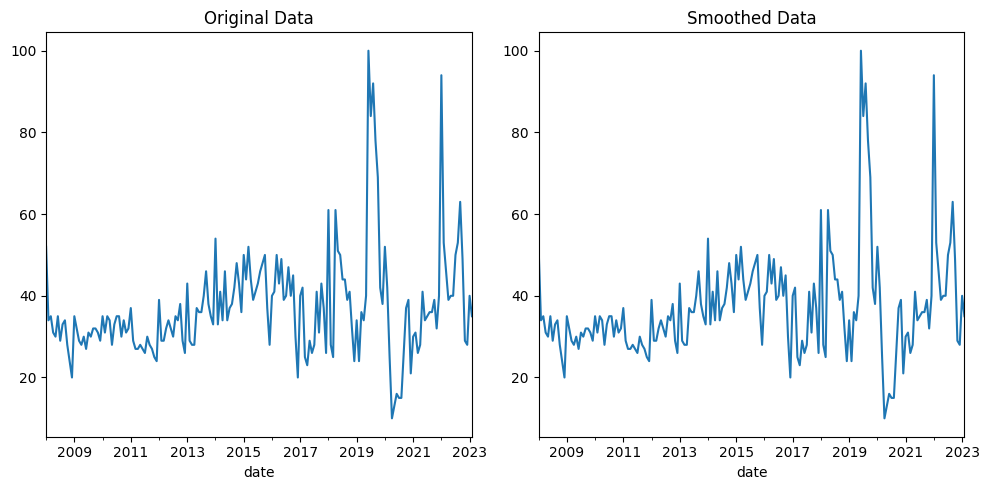

In [111]:
import matplotlib.pyplot as plt

a_country = 'VE'
topic = 'Travel Visa'

# Set the desired figsize
figsize = (10, 5)

# Create a figure with the specified figsize and a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=figsize)

# Plot the first line on the left subplot
test.loc[test.country == a_country, topic].plot.line(ax=axes[0])
axes[0].set_title('Original Data')

# Plot the second line on the right subplot
smooth_spikes(test.loc[test.country == a_country, topic]).plot.line(ax=axes[1])
axes[1].set_title('Smoothed Data')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [120]:
import pycountry_convert as pc

def country_to_continent(iso2):
    # if iso3 == 'UVK':
    #     return 'EU'
    if iso2 =='TL':
        return 'OC'
    # elif iso3 =='WBG':
    #     return 'AS'

    #country_alpha2 = pc.country_alpha3_to_country_alpha2(iso3)
    country_continent_code = pc.country_alpha2_to_continent_code(iso2)
    return country_continent_code

def mapper(series, converter):
    unique_keys = series.drop_duplicates()
    unique_vals = unique_keys.apply(converter)
    mapper_dict = dict(zip(unique_keys, unique_vals))
    series = series.map(mapper_dict)
    series.name = series.name + '_continent'
    return series

continents = test[['country']].apply(lambda x: mapper(x, country_to_continent)).rename({'country':'continent'}, axis=1)
test = pd.concat([continents, test], axis=1)

In [126]:
test.continent.unique()

array(['AS', 'EU', 'AF', 'NA', 'SA', 'OC'], dtype=object)

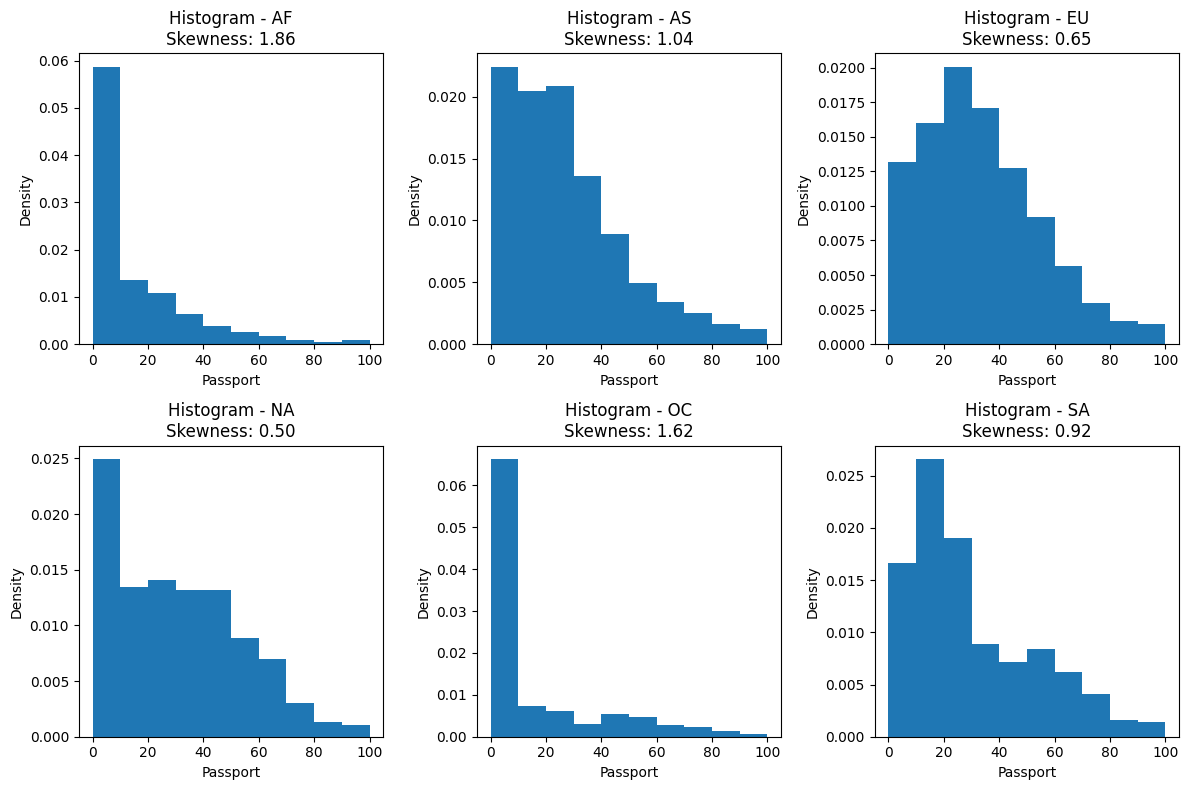

In [251]:
import matplotlib.pyplot as plt
from scipy.stats import skew

# Group the DataFrame
groups = test.groupby('continent')

# Create a new figure with a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the groups
for i, (group_name, group_data) in enumerate(groups):
    # Determine the subplot coordinates
    row = i // 3  # Row index
    col = i % 3   # Column index
    
    # Plot histogram for each group with normalization
    axes[row, col].hist(group_data['passport'], density=True)
    
    # Calculate skewness
    skewness = skew(group_data['passport'], nan_policy='omit')
    
    # Set title and labels
    axes[row, col].set_title(f'Histogram - {group_name}\nSkewness: {skewness:.2f}')
    axes[row, col].set_xlabel('Passport')
    axes[row, col].set_ylabel('Density')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


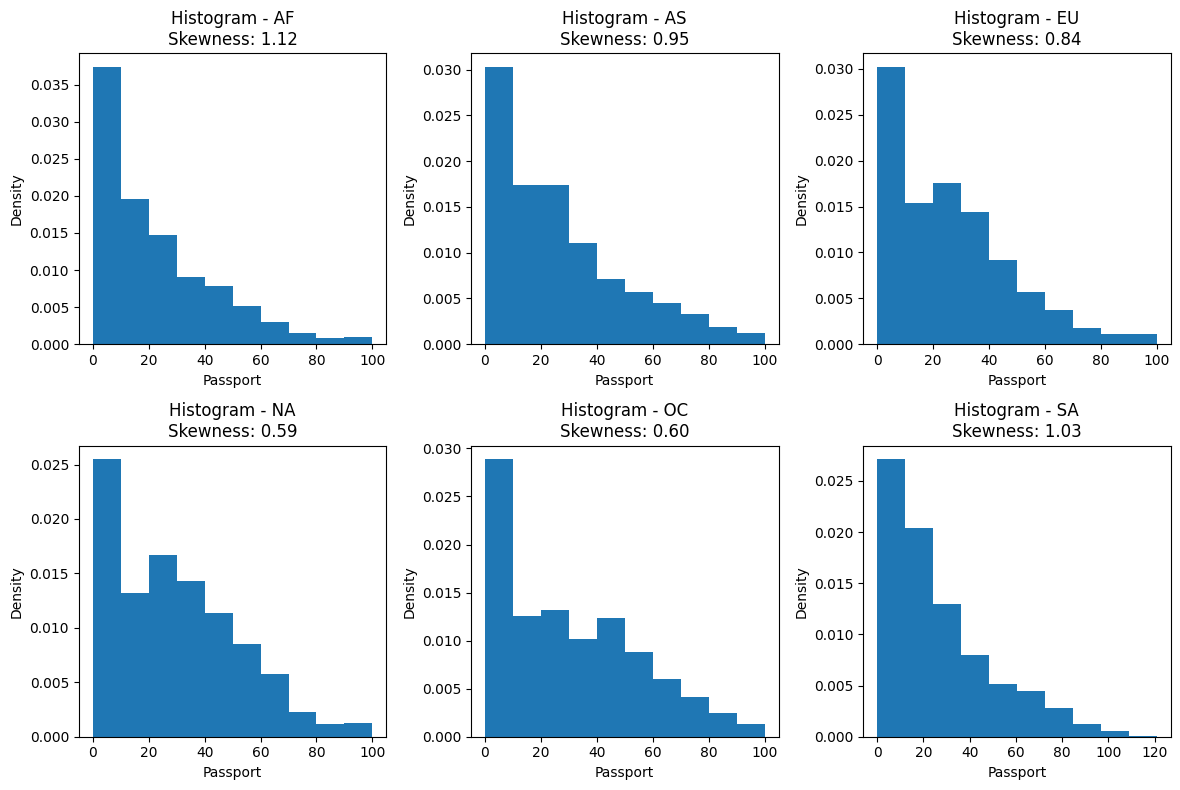

In [252]:
test2= pd.concat([test.continent, test.groupby('country').passport.apply(smooth_spikes, aggressive = True).reset_index().set_index('date')], axis=1)

# Group the DataFrame
groups = test2.groupby('continent')

# Create a new figure with a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the groups
for i, (group_name, group_data) in enumerate(groups):
    # Determine the subplot coordinates
    row = i // 3  # Row index
    col = i % 3   # Column index
    
    # Plot histogram for each group with normalization
    axes[row, col].hist(group_data['passport'], density=True)
    
    # Calculate skewness
    skewness = skew(group_data['passport'], nan_policy='omit')
    
    # Set title and labels
    axes[row, col].set_title(f'Histogram - {group_name}\nSkewness: {skewness:.2f}')
    axes[row, col].set_xlabel('Passport')
    axes[row, col].set_ylabel('Density')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [246]:
from scipy.stats import skew

test.groupby('continent').passport.agg(skew, nan_policy='omit')

continent
AF    1.856237
AS    1.044144
EU    0.649832
NA    0.501738
OC    1.616922
SA    0.922628
Name: passport, dtype: float64

In [247]:
test2.groupby('continent').passport.agg(skew, nan_policy='omit')

continent
AF    1.123839
AS    0.948817
EU    0.837931
NA    0.593899
OC    0.595213
SA    1.028228
Name: passport, dtype: float64

In [214]:
test3 = pd.concat([test[['passport','country','continent']], test2.passport.rename('passport_smooth') ], axis=1)
test3[(test3.continent == 'EU') & (test3.passport - test3.passport_smooth > 40)]

,passport,country,continent,passport_smooth
date,,,,
2008-07-01,93.0,AL,EU,27.0
2008-09-01,100.0,AL,EU,32.0
2008-12-01,78.0,AL,EU,24.0
2008-09-01,63.0,AD,EU,0.0
2009-04-01,100.0,AD,EU,27.0
...,...,...,...,...
2022-03-01,72.0,GB,EU,29.0
2022-04-01,90.0,GB,EU,28.0
2022-05-01,100.0,GB,EU,28.0


In [248]:
test3 = test.groupby('country').passport.apply(smooth_spikes, aggressive=True).reset_index().rename({'passport':'passport_smoothed'},axis=1).merge(test.reset_index()[['passport','country','date','continent']], on=['country','date']).set_index('date')
test3[(test3.continent == 'AS') & (test3.passport_smoothed- test3.passport  > 20)]

,country,passport_smoothed,passport,continent
date,,,,
2008-05-01,BT,58.139535,25.0,AS
2008-10-01,BT,58.139535,25.0,AS
2009-06-01,BT,44.186047,19.0,AS
2009-10-01,BT,74.418605,32.0,AS
2010-04-01,BT,48.837209,21.0,AS
...,...,...,...,...
2022-08-01,MM,100.000000,45.0,AS
2022-09-01,MM,86.666667,39.0,AS
2022-10-01,MM,77.777778,35.0,AS


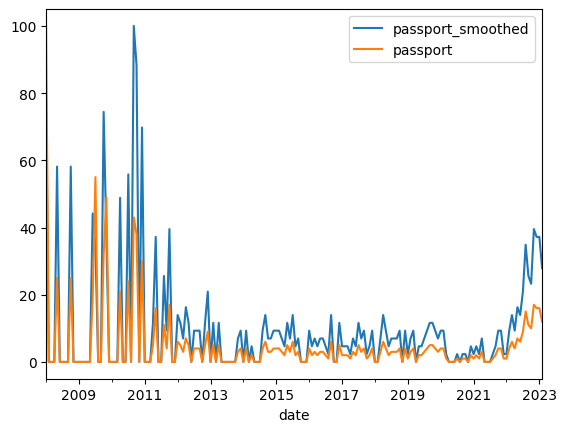

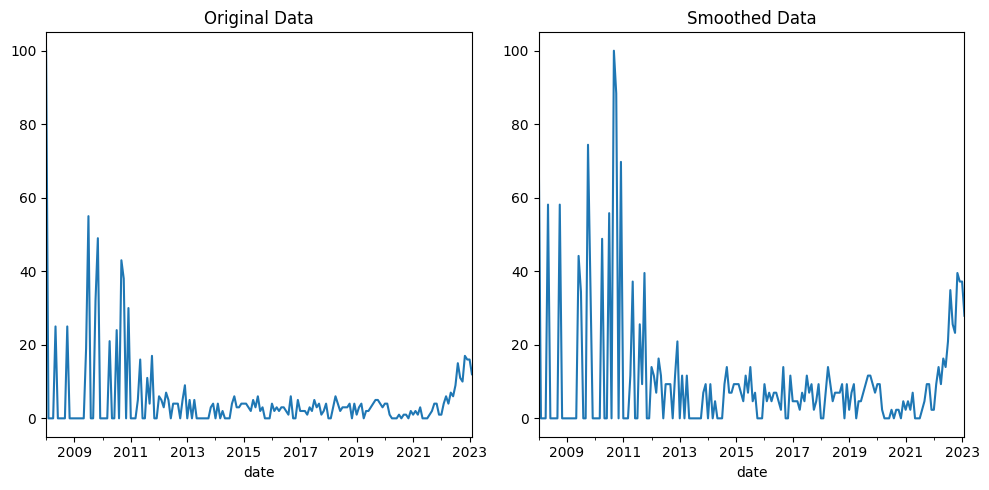

In [249]:
test3[test3.country == 'BT'].plot()

a_country = 'BT'
topic = 'Travel Visa'

# Set the desired figsize
figsize = (10, 5)

# Create a figure with the specified figsize and a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=figsize)

# Plot the first line on the left subplot
test3.passport[test3.country == a_country].plot.line(ax=axes[0])
axes[0].set_title('Original Data')

# Plot the second line on the right subplot
smooth_spikes(test3.passport_smoothed[test3.country == a_country]).plot.line(ax=axes[1])
axes[1].set_title('Smoothed Data')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<Axes: xlabel='date'>

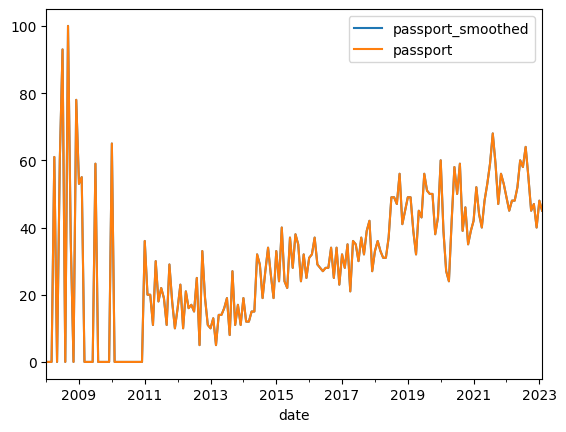

In [244]:
test3[test3.country == 'AL'].plot()

Ok, let's assume we have a good function to smooth the data.

In [510]:
import pandas as pd

# trends data
trends_path = '../notebooks/trends/data/'
semantic_trends = pd.read_csv(trends_path + 'semantic_topic_trends.csv').drop('Unnamed: 0', axis=1).melt(id_vars=['date','country'], var_name= 'keyword')
main_cities_trends = pd.read_csv(trends_path + 'city_topic_trends_1.csv').rename({'Unnamed: 0':'date'}, axis=1).melt(id_vars=['date','country_o'], var_name='city').dropna()
countries_trends = pd.read_csv(trends_path + 'country_topic_trends_1.csv').drop('Unnamed: 0', axis=1)
border_cities_trends = pd.read_csv(trends_path + 'bordering_cities_trends.csv').rename({'Unnamed: 0':'date'}, axis=1).melt(id_vars=['date','country_d','country_o']).dropna()

# topic ids
semantic_topic_ids = pd.read_csv('../notebooks/trends/topic_ids/semantic_topic_ids.csv').replace(['Social','Civil'], 'Civil/Social').replace('Refugee','Travel')
neighboring_city_ids = pd.read_csv('../notebooks/trends/topic_ids/neighboring_city_topic_id.csv')
city_topic_id = pd.read_csv('../notebooks/trends/topic_ids/city_topic_id.csv')
country_topic_id = pd.read_csv('../notebooks/trends/topic_ids/country_topic_ids.csv')

In [326]:
# Define the agg_year function
def agg_category(series):

    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','median','75th','max'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

### Semantic Trends
I aggregate the data, grouping the terms into the following categories:
| Category          | Topics                                      |
|-------------------|---------------------------------------------|
| Travel            | passport, Immigration, Travel Visa, Refugee |
| Conflict/Violence | Conflict, War, Violence, Crisis, Militia, Genocide, Armed Forces, Civilian |
| Economic          | Economy, Currency, Lottery, Bureau de change, Wage |
| Social/Civil      | Protest, Coup d’état, Government             |

In [ ]:
semantic_trends = semantic_trends.merge(semantic_topic_ids[['Category','keyword']], how='left',on='keyword').groupby(['country','Category','date']).value.agg(agg_category)
semantic_trends = pd.concat([semantic_trends.reset_index()[['country','Category','date']], split_nested_list(semantic_trends).reset_index(drop=True)], axis=1).pivot(index=['country','date'], columns='Category', values = ['value_min', 'value_25th','value_median','value_75th','value_max'])
semantic_trends.columns = ['_'.join(col) for col in semantic_trends.columns]

In [498]:
semantic_trends.to_csv('../data/clean/trends/semantic_trends.csv')

I combine the main cities and the bordering cities of neighboring countries data, and create two datasets: (1) general to neighboring destination countries, (2) specific to each destination country

In [484]:
main_cities_trends = pd.concat([main_cities_trends.drop('city',axis=1).reset_index(drop=True), main_cities_trends.city.str.split(', ', expand=True, n =1).reset_index(drop=True).rename({0:'city',1:'country'}, axis=1)] ,axis=1).merge(city_topic_id, left_on=['city','country'], right_on=['topic_title','search_country'], how='left').drop('search_country', axis=1)
main_cities_trends = pd.concat([main_cities_trends.rename({'country':'country_d'}, axis=1), border_cities_trends.rename({'variable':'topic_mid'}, axis=1)], axis=0).drop_duplicates(['topic_mid','country_o','date'])

In [485]:
city_ids = pd.concat([city_topic_id[['topic_title','topic_mid']],neighboring_city_ids[['topic_title','topic_mid']]], axis=0).drop_duplicates()
city_trends = main_cities_trends.drop(['search_keyword','topic_type', 'city', 'topic_title'], axis=1).merge(city_ids, on = 'topic_mid', how='left').drop_duplicates(['date','country_o','topic_mid']).drop('topic_mid', axis=1)

In [489]:
city_trends_outflow = city_trends.groupby(['date','country_o']).value.agg(agg_category)
city_trends_outflow_index = city_trends_outflow.reset_index().drop('value', axis=1)
city_trends_outflow = split_nested_list(city_trends_outflow)
city_trends_outflow.columns = 'cities_' + pd.Series(city_trends_outflow.columns)
city_trends_outflow = pd.concat([city_trends_outflow_index, city_trends_outflow], axis=1)

In [503]:
city_trends_outflow.to_csv('../data/clean/trends/city_trends_outflow.csv')

In [490]:
city_trends_corridor = city_trends.groupby(['date','country_o','country_d']).value.agg(agg_category)
city_trends_corridor_index = city_trends_corridor.reset_index().drop('value', axis=1)
city_trends_corridor = split_nested_list(city_trends_corridor)
city_trends_corridor.columns = 'cities_' + pd.Series(city_trends_corridor.columns)
city_trends_corridor = pd.concat([city_trends_corridor_index, city_trends_corridor], axis=1)

In [502]:
city_trends_corridor.to_csv('../data/clean/trends/city_trends_corridor.csv')

I aggregate the neighboring country dataset, creating a corridor and outflow datasets.

In [529]:
countries_trends.merge(country_topic_id[['topic_mid','topic_title']], how='left',on='topic_mid').drop('topic_mid', axis=1).to_csv('clean/trends/country_trends_corridor.csv', index=False)

In [ ]:
countries_trends_outflow = countries_trends.merge(country_topic_id[['topic_mid','topic_title']], how='left',on='topic_mid').drop('topic_mid', axis=1).groupby(['date','country_o']).value.agg(agg_category)
countries_trends_outflow_index = countries_trends_outflow.reset_index().drop('value',axis=1)
countries_trends_outflow = split_nested_list(countries_trends_outflow)
countries_trends_outflow.columns = 'countries_' + pd.Series(countries_trends_outflow.columns)
countries_trends_outflow = pd.concat([countries_trends_outflow_index, countries_trends_outflow], axis=1)

In [527]:
countries_trends_outflow.to_csv('clean/trends/countries_trends_outflow.csv', index=False)